
# Predicting Air Pollution Levels using Random Forest

This notebook demonstrates the steps to use a Random Forest model to predict air pollution levels.


In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


## Load Data

Load your training and testing data from CSV files.


In [2]:
# set random seed
np.random.seed(42)

df_test = pd.read_csv('prepped_data/test_data.csv')
df_train = pd.read_csv('prepped_data/train_data.csv')

In [39]:
# check date range of the data
df_train['date'].min(), df_train['date'].max(), df_test['date'].min(), df_test['date'].max()

('2021-05-06', '2022-04-29', '2022-05-03', '2022-08-05')

In [3]:
# Define a function to reposition and rename columns
def reposition_and_rename_columns(df):
    # Get the column names
    columns = df.columns.tolist()

    # Remove the 'Hour' and 'Sum_Volume' columns from the list
    columns.remove('Hour')
    columns.remove('Sum_Volume')

    # Insert 'hour' column at the 8th position
    columns.insert(11, 'Hour')

    # Insert 'traffic_volume_sum' column at the 9th position
    columns.insert(12, 'Sum_Volume')

    # Reorder the DataFrame with the new column order
    df = df[columns]  # Reordering columns without reindexing

    # Rename columns
    df = df.rename(columns={'Hour': 'hour', 'Sum_Volume': 'traffic_volume_sum'})

    return df

# Reposition and rename columns for df_train
df_train = reposition_and_rename_columns(df_train)

# Reposition and rename columns for df_test
df_test = reposition_and_rename_columns(df_test)

In [4]:
df_train

,date,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,SiteID,Lat,Long,...,DCC-AQ5-pm4,DCC-AQ52-pm4,DCC-AQ6-pm4,DCC-AQ1-so2,DCC-AQ13-so2,DCC-AQ22-so2,TNO2161-tsp,TNO2162-tsp,TNO4435-tsp,TNT1088-tsp
0,2021-05-06,-16.485096,4.267365,70.815263,0.275750,786.544417,3.815981,325,53.327618,-6.309232,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.9,8.78
1,2021-05-06,-0.466100,11.630600,71.484000,0.282222,800.609500,7.049500,770,53.335275,-6.317469,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.2,4.30
2,2021-05-06,32.199310,14.004828,61.570000,0.404724,795.937567,3.140167,619,53.326383,-6.322198,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.2,4.30
3,2021-05-06,24.686167,31.937167,54.446000,0.567000,830.621600,9.055143,487,53.329272,-6.334426,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.2,4.30
4,2021-05-06,0.391708,-6.196404,80.784941,0.293809,790.788080,3.640216,547,53.306713,-6.301091,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.9,8.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,2022-04-29,54.393625,22.326125,58.886000,0.763000,NaN,16.530875,45,53.348265,-6.308470,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,NaN,6.50
34919,2022-04-29,8.136800,3.548273,74.203750,0.305200,792.278818,17.119000,717,53.341981,-6.316828,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,NaN,6.50
34920,2022-04-29,40.311571,17.494600,57.480000,0.297167,777.945143,19.670143,412,53.342280,-6.346188,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,NaN,6.50
34921,2022-04-29,16.123478,16.651783,66.063333,0.306870,772.755333,17.682042,651,53.342196,-6.328940,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,NaN,6.50


Mean Imputation
---

In [8]:
# Option to keep column names

from sklearn.impute import SimpleImputer

# Save the column names
column_names = df_train.columns

# Split train into X and Y
Xtrain = df_train.iloc[:, 7:].copy()  # Retain the column names by using copy
ytrain = df_train["PM25_ugm3"].values

# Split test into X and Y
Xtest = df_test.iloc[:, 7:].copy()  # Retain the column names by using copy
ytest = df_test["PM25_ugm3"].values

# Running a simple imputer and scaler
imputer = SimpleImputer(strategy="mean")
Xtrain_imputed_mean = pd.DataFrame(imputer.fit_transform(Xtrain), columns=Xtrain.columns)  # Assigning column names back
Xtest_imputed_mean = pd.DataFrame(imputer.transform(Xtest), columns=Xtest.columns)  # Assigning column names back

# no need to scale for random forest
# scaler = StandardScaler()
# Xtrain_scaled = pd.DataFrame(scaler.fit_transform(Xtrain_imputed), columns=Xtrain_imputed.columns)  # Assigning column names back
# Xtest_scaled = pd.DataFrame(scaler.transform(Xtest_imputed), columns=Xtest_imputed.columns)  # Assigning column names back

In [9]:
Xtrain_imputed_mean

,SiteID,Lat,Long,day_of_week,hour,traffic_volume_sum,avgtempC,maxtempC,mintempC,sunHour,...,DCC-AQ5-pm4,DCC-AQ52-pm4,DCC-AQ6-pm4,DCC-AQ1-so2,DCC-AQ13-so2,DCC-AQ22-so2,TNO2161-tsp,TNO2162-tsp,TNO4435-tsp,TNT1088-tsp
0,325.0,53.327618,-6.309232,3.0,14.0,0.00000,6.0,9.0,1.0,12.0,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.900000,8.78
1,770.0,53.335275,-6.317469,3.0,13.0,1154.59771,6.0,9.0,1.0,12.0,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.200000,4.30
2,619.0,53.326383,-6.322198,3.0,13.0,1154.59771,6.0,9.0,1.0,12.0,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.200000,4.30
3,487.0,53.329272,-6.334426,3.0,13.0,1910.00000,6.0,9.0,1.0,12.0,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.200000,4.30
4,547.0,53.306713,-6.301091,3.0,14.0,1154.59771,6.0,9.0,1.0,12.0,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.900000,8.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,45.0,53.348265,-6.308470,4.0,10.0,1451.00000,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,15.063171,6.50
34919,717.0,53.341981,-6.316828,4.0,10.0,1154.59771,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,15.063171,6.50
34920,412.0,53.342280,-6.346188,4.0,10.0,0.00000,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,15.063171,6.50
34921,651.0,53.342196,-6.328940,4.0,10.0,855.00000,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,15.063171,6.50


KNN Imputation
---

In [5]:
# Option to keep column names
from sklearn.impute import KNNImputer

# set random seed
np.random.seed(42)

# Split train into X and Y
Xtrain_KNN = df_train.iloc[:, 7:].copy()  # Retain the column names by using copy

# Split test into X and Y
Xtest_KNN = df_test.iloc[:, 7:].copy()  # Retain the column names by using copy

# Perform KNN imputation on the train and test data
imputer = KNNImputer(n_neighbors=5)
Xtrain_KNN_imputed = pd.DataFrame(imputer.fit_transform(Xtrain_KNN), columns=Xtrain_KNN.columns)  # Assigning column names back
Xtest_KNN_imputed = pd.DataFrame(imputer.transform(Xtest_KNN), columns=Xtest_KNN.columns)  # Assigning column names back

# Scale the data (not needed for random forest)
# Xtrain_KNN_scaled = pd.DataFrame(scaler.fit_transform(Xtrain_KNN_imputed), columns=Xtrain_KNN_imputed.columns)  # Assigning column names back
# Xtest_KNN_scaled = pd.DataFrame(scaler.transform(Xtest_KNN_imputed), columns=Xtest_KNN_imputed.columns)  # Assigning column names back

In [6]:
Xtrain_KNN_imputed

,SiteID,Lat,Long,day_of_week,hour,traffic_volume_sum,avgtempC,maxtempC,mintempC,sunHour,...,DCC-AQ5-pm4,DCC-AQ52-pm4,DCC-AQ6-pm4,DCC-AQ1-so2,DCC-AQ13-so2,DCC-AQ22-so2,TNO2161-tsp,TNO2162-tsp,TNO4435-tsp,TNT1088-tsp
0,325.0,53.327618,-6.309232,3.0,14.0,0.0,6.0,9.0,1.0,12.0,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.900,8.78
1,770.0,53.335275,-6.317469,3.0,13.0,643.6,6.0,9.0,1.0,12.0,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.200,4.30
2,619.0,53.326383,-6.322198,3.0,13.0,323.6,6.0,9.0,1.0,12.0,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.200,4.30
3,487.0,53.329272,-6.334426,3.0,13.0,1910.0,6.0,9.0,1.0,12.0,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.200,4.30
4,547.0,53.306713,-6.301091,3.0,14.0,896.4,6.0,9.0,1.0,12.0,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.900,8.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,45.0,53.348265,-6.308470,4.0,10.0,1451.0,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,19.510,6.50
34919,717.0,53.341981,-6.316828,4.0,10.0,748.4,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,27.594,6.50
34920,412.0,53.342280,-6.346188,4.0,10.0,0.0,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,27.080,6.50
34921,651.0,53.342196,-6.328940,4.0,10.0,855.0,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,27.572,6.50


In [ ]:
# save with column names

# Xtrain_KNN_imputed.to_csv('prepped_data/with_column_names/Xtrain_KNN.csv', index=False)
# Xtrain_KNN_imputed.to_csv('prepped_data/with_column_names/Xtest_KNN.csv', index=False)
# ytrain.to_csv('prepped_data/with_column_names/ytrain.csv', index=False)
# ytest.to_csv('prepped_data/with_column_names/ytest.csv', index=False)


## Train the Random Forest Model

Here we will configure and train our Random Forest model.


In [10]:
# shapes of the data
Xtrain_KNN_imputed.shape, ytrain.shape, Xtest_KNN_imputed.shape, ytest.shape

((34923, 85), (34923,), (8272, 85), (8272,))

`TimeSeriesSplit` is used to split the training data into multiple training and validation sets. Then, a Random Forest Regressor is trained and evaluated on each split. Finally, the RMSE scores of each fold are printed along with the mean RMSE score across all folds.

In [65]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Reset index of Xtrain_KNN_imputed
Xtrain_KNN_imputed.reset_index(drop=True, inplace=True)

# Define the number of splits (e.g., 5 splits)
n_splits = 5

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = []
for train_index, test_index in tscv.split(Xtrain_KNN_imputed):
    X_train, X_test = Xtrain_KNN_imputed.iloc[train_index], Xtrain_KNN_imputed.iloc[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]

    # Train the model
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    cv_scores.append(rmse)

# Print cross-validation RMSE scores
print("Cross-Validation RMSE scores:", cv_scores)
print("Mean Cross-Validation RMSE:", np.mean(cv_scores))

Cross-Validation RMSE scores: [9.245251413776016, 9.124257497483752, 11.517070976781099, 11.4537878531756, 8.055581157931066]
Mean Cross-Validation RMSE: 9.879189779829506


## Tune Model Hyperparameters

This code performs grid search using cross-validation to find the best hyperparameters for a RandomForestRegressor model.
-  number of trees in the random forest (n_estimators)
- maximum depth of the tree (max_depth)
- minimum number of samples required to split an internal node (min_samples_split)

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

# If taking too long: Define a subset of data for tuning
# subset_size = 15000
# X_train_subset, y_train_subset = Xtrain_KNN_imputed[:subset_size], ytrain[:subset_size]

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [5, 10, 20, 30, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform GridSearchCV with TimeSeriesSplit for cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
# grid_search.fit(X_train_subset, y_train_subset)
grid_search.fit(Xtrain_KNN_imputed, ytrain)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


In [ ]:
# Best Hyperparameters for subset of 15000: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


# Best Hyperparameters for full dataset: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
## Results full dataset: Test RMSE: 6.664, R-squared: -0.479

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Set random seed for reproducibility
np.random.seed(42)


# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 75, 100],  # Include 50 which gave better results and explore slightly more and fewer estimators
    'max_depth': [5, 10, 15, 20],   # Explore shallower and slightly deeper trees
    'max_features': ['sqrt', 'log2'],  # Continue to explore feature subset strategies
    'min_samples_leaf': [1, 2, 4],  # Explore a range that allows more generalization
    'min_samples_split': [2, 5, 10]  # Explore values around 5 which performed well
}

# Initialize RandomForestRegressor and TimeSeriesSplit
rf = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize and perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use built in RMSE as scoring metric
    cv=tscv,
    verbose=2, # more detailed output during the grid search
    n_jobs=-1 # high CPU usage
)

# Fit GridSearchCV
grid_search.fit(Xtrain_KNN_imputed, ytrain)

# Output best parameters and corresponding RMSE
print("Best parameters:", grid_search.best_params_)
print("Raw Best Score from GridSearchCV:", grid_search.best_score_)

# Calculate RMSE from the negative value
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE: {best_rmse}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}
Raw Best Score from GridSearchCV: -7.506333972155405
Best RMSE: 2.7397689632805546


Key Takeaways
---
- The best parameters identified `({'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100})` suggest that the RF-model benefits from a deeper tree (max_depth: 30), which implies more complex decision paths that are well suited to capturing patterns in our dataset
- An RMSE of approximately 2.823 indicates that on average, the predictions of this RF-model are about 2.823 units away from the actual values

In [ ]:
### 
# simple_best_params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
# Test RMSE: 6.664, 
# R-squared: -0.479


###
# best_params_01 = {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# Test RMSE: 5.974255740945378
# R-squared: -0.18869356799085102


###
# best_params_02 = {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}
# Test RMSE: 5.974255740945378
# R-squared: -0.18869356799085102
# feature importance: lat, long, site_id, traffic_volume_sum


## Predict and Evaluate the Model

Now, let's make predictions on the test set and evaluate the model.


In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

best_params = {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# Initialize RandomForestRegressor with best hyperparameters
best_rf = RandomForestRegressor(random_state=42, **best_params) # **best_params

# Train the model on the full training data
best_rf.fit(Xtrain_KNN_imputed, ytrain)

# Make predictions on the test set
y_pred = best_rf.predict(Xtest_KNN_imputed)

# Calculate RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print("Test RMSE:", test_rmse)

# Calculate R-squared score
r2 = r2_score(ytest, y_pred)
print("R-squared:", r2)

Test RMSE: 5.974255740945378
R-squared: -0.18869356799085102


The test RMSE value of approximately 5.21 indicates the average difference between the actual and predicted traffic volume values is around 5.21, which is an improvement compared to your previous results.However, the R-squared value of approximately 0.097 suggests that the model explains only about 9.7% of the variance.

Overall, a test RMSE of 6.664 suggests that our RandomForestRegressor model is making reasonably accurate predictions on the test data.


## Feature Importance

Visualize the importance of each feature in making predictions.


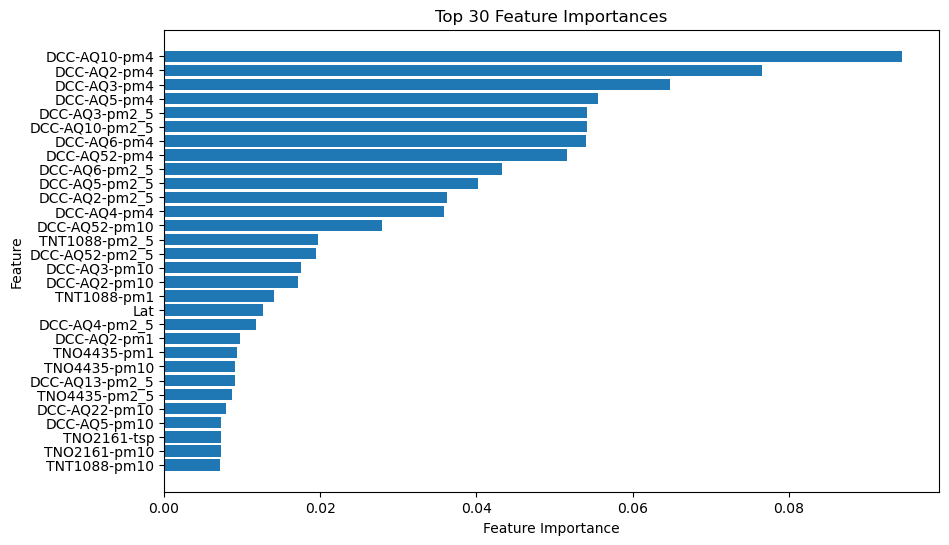

In [84]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
feature_importances = best_rf.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the top N features and their importances
top_n = 30  # Adjust this value based on your preference
top_features = Xtrain_KNN_imputed.columns[sorted_indices][:top_n]
top_importances = feature_importances[sorted_indices][:top_n]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances, align='center')
plt.yticks(range(top_n), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top {} Feature Importances'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature at the top
plt.show()

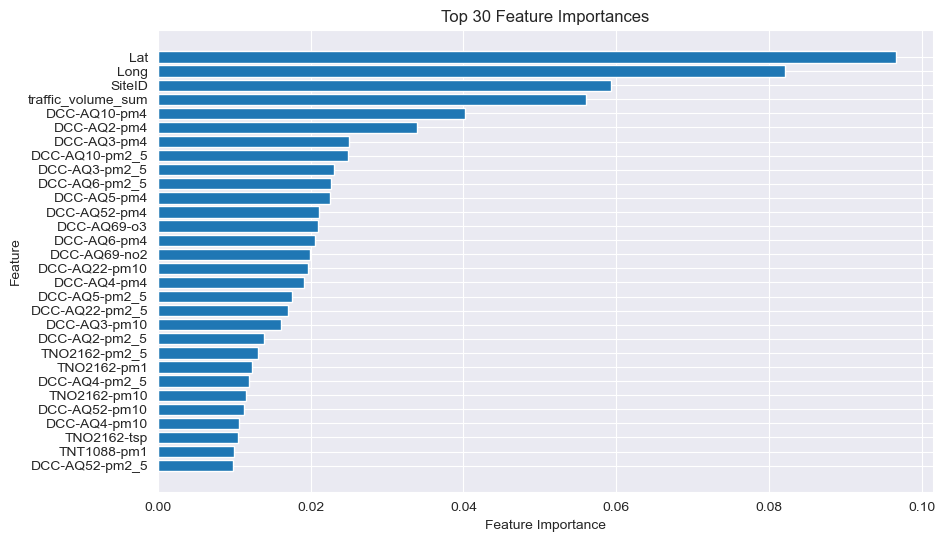

In [38]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
feature_importances = best_rf.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the top N features and their importances
top_n = 30  # Adjust this value based on your preference
top_features = Xtrain_KNN_imputed.columns[sorted_indices][:top_n]
top_importances = feature_importances[sorted_indices][:top_n]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances, align='center')
plt.yticks(range(top_n), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top {} Feature Importances'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature at the top
plt.show()